# Let's Face It 

**Team Members:** Georgiy Sekretaryuk, Rafael Arbex-Murut, Yeshwanth Somu

**Data Set:** Facial Recognition Dataset
- https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset?select=Testing

**Data Set Description:**

This dataset contains folders pertaining to different expressions of the human face, such as Surprise, Anger, Happiness, Sad, Neutral, Fear. The training set consists of 28,079 samples in total with the testing set consisting of 7,178 samples in total. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The purpose of this project is to analyze facial images to predict emotion.

**Number of Attributes:** 2304

**Attribute Description:** Each attribute is a grayscale value of each of the 48 x 48 pixels.

**Data Source:** Kaggle

In [57]:
# SETUP

import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn import metrics
tf.get_logger().setLevel('INFO')

### Loading Data

In [24]:
# Function to load images from a folder
def load_images_from_folder(folder_path, label_mapping):
    images = []
    labels = []

    #load each image file
    for filename in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, filename))

        #check if loaded properly
        if img is not None:

            images.append(np.array(img)) #turn image to array
            folder_name = folder_path.split('/')[-1]  # Extract folder name from path
            label = label_mapping[folder_name]  # Assign label based on folder name
            labels.append(label)  # Assign the folder index as the label

    return images, labels

def load_dataset(data_folder, return_label_names=False):
    X = []
    Y = []

    label_mapping = {}  # Dictionary to map folder names to label values
    label_counter = 0

    #cycle through each folder, get folder path
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        # print("Load_dataset is looping through", folder_path)

        #check if a folder or a stray file
        if os.path.isdir(folder_path):

            #count folders to assign index
            label_mapping[folder_name] = label_counter
            label_counter += 1

            #load images and labels, add to X/Y list
            images, labels = load_images_from_folder(folder_path, label_mapping)
            X.extend(images)
            Y.extend(labels)
    
        else:
            print(f"{folder_path} is not a folder.")

    #pull out label names
    label_names = list(label_mapping.keys())

    if return_label_names:
        label_names = list(label_mapping.keys())
        return np.array(X), np.array(Y), label_names
    else:
        return np.array(X), np.array(Y)

# Load the training dataset
train_folder = 'data/Training/Training'
X_train, Y_train, label_names = load_dataset(train_folder, return_label_names=True)

# Load the testing dataset
test_folder = 'data/Testing/Testing'
X_test, Y_test, = load_dataset(test_folder)

# Flatten the label vectors
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()


data/Testing/Testing/.DS_Store is not a folder.


In [26]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print(label_names)

print(Y_train)

X_train.shape: (28273, 48, 48)
Y_train.shape: (28273,)
X_test.shape: (7067, 48, 48)
Y_test.shape: (7067,)
['Happy', 'Sad', 'Fear', 'Neutral', 'Angry', 'Suprise']
[0 0 0 ... 5 5 5]


In [19]:
X_train = X_train / 255
X_test = X_test / 255

### Visualizing Images in Dataset

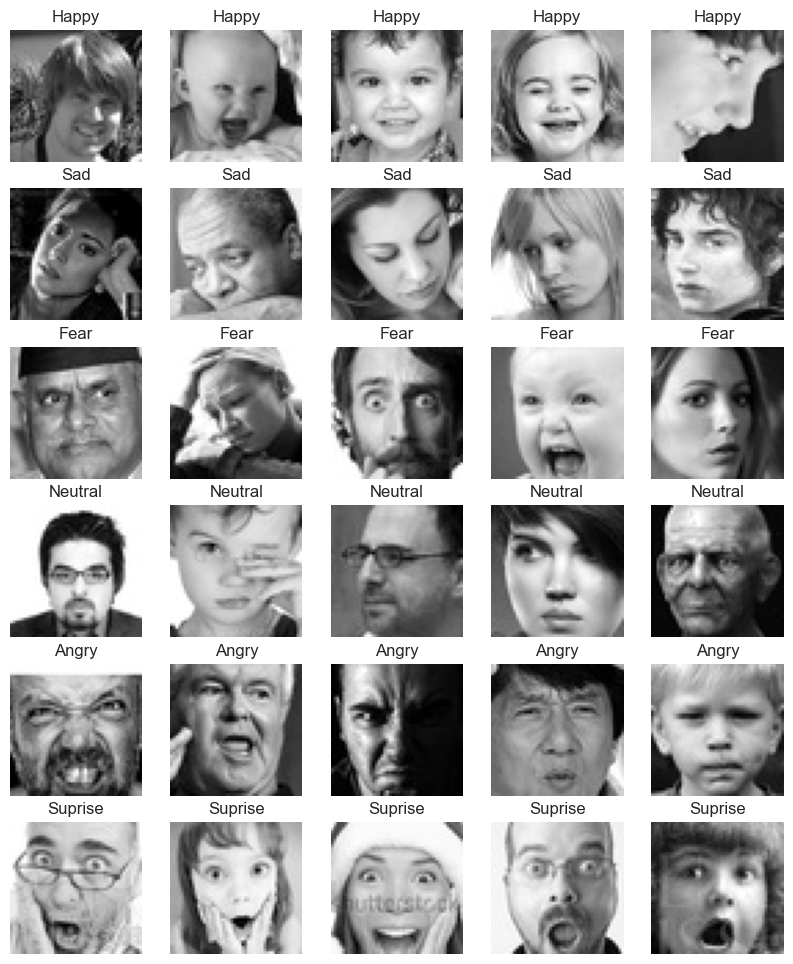

In [33]:
#plot 5 images for each label

num_images_to_show = 5

fig, axs = plt.subplots(len(label_names), ncols=num_images_to_show, figsize=(10, 12))
for label in range(len(label_names)):
    counter = 0 
    for i in range(len(Y_train)):
        if Y_train[i] == label:
            image = X_train[i]
            axs[label, counter].imshow(image, cmap='gray')
            axs[label, counter].set_title(label_names[label])
            axs[label, counter].axis('off')
            counter += 1

            #if loaded 5 images per row/label, break
            if counter == 5:  
                break
plt.show()

### Building the Model

In [46]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

In [37]:
# def log_loss(Y_true, Y_pred):
#   """Returns the binary log loss for a list of labels and predictions.
  
#   Args:
#     Y_true: A list of (true) labels (0 or 1)
#     Y_pred: A list of corresponding predicted probabilities

#   Returns:
#     Binary log loss
#   """
#   Y_true = np.array(Y_true)
#   Y_pred_baseline = np.ones_like(Y_pred) * 0.1

#   # Compute the binary log loss for the true labels and predicted probabilities
#   loss = -np.mean(Y_true * np.log(Y_pred_baseline) + (1 - Y_true) * np.log(1 - Y_pred_baseline))

#   return loss

In [47]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
  model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, 
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

In [54]:
model = build_model(len(label_names), 0.03)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
398/398 [==============================] - 3s 7ms/step - loss: 383312.3438 - accuracy: 0.1947 - val_loss: 541263.0000 - val_accuracy: 0.1856
Epoch 2/5
398/398 [==============================] - 3s 7ms/step - loss: 324892.5938 - accuracy: 0.2180 - val_loss: 220611.7500 - val_accuracy: 0.2617
Epoch 3/5
398/398 [==============================] - 3s 7ms/step - loss: 305661.2812 - accuracy: 0.2304 - val_loss: 455652.6250 - val_accuracy: 0.1616
Epoch 4/5
398/398 [==============================] - 3s 6ms/step - loss: 288004.1250 - accuracy: 0.2359 - val_loss: 264331.1562 - val_accuracy: 0.2111
Epoch 5/5
398/398 [==============================] - 3s 6ms/step - loss: 284958.8438 - accuracy: 0.2376 - val_loss: 254982.2031 - val_accuracy: 0.1602


,loss,accuracy,val_loss,val_accuracy
0,383312.34375,0.194655,541263.000000,0.185644
1,324892.59375,0.218000,220611.750000,0.261669
2,305661.28125,0.230379,455652.625000,0.161598
3,288004.12500,0.235921,264331.156250,0.211103
4,284958.84375,0.237571,254982.203125,0.160184


In [55]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

221/221 [==============================] - 1s 2ms/step
[2 2 2 ... 2 5 2]


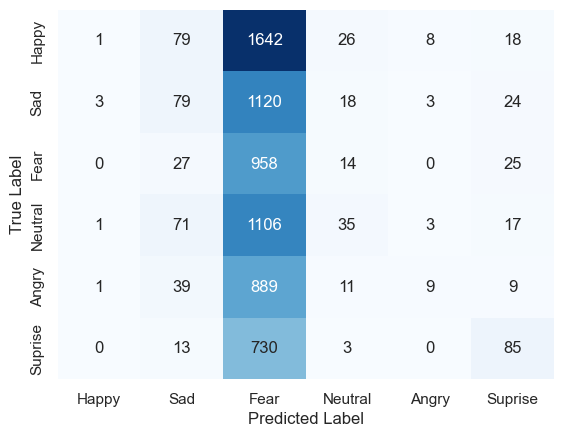

              precision    recall  f1-score   support

           0      0.167     0.001     0.001      1774
           1      0.256     0.063     0.102      1247
           2      0.149     0.936     0.257      1024
           3      0.327     0.028     0.052      1233
           4      0.391     0.009     0.018       958
           5      0.478     0.102     0.168       831

    accuracy                          0.165      7067
   macro avg      0.295     0.190     0.100      7067
weighted avg      0.275     0.165     0.087      7067



In [60]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.4g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

print(metrics.classification_report(Y_test, test_predictions, digits=3))